# Tacotron-2 training

This notebook provides examples to 
1. Create a new Tacotron2 model
2. Load dataset, test and analyze it
3. Train the model on this dataset
4. Complete inference with the `Waveglow` NVIDIA's pretrained vocoder*

*Note that this inference is not optimal (see the `speech_to_text` notebook) but it can be useful for testing your model

**Important note** : `Waveglow` is a `pytorch` model so it does not coexist properly with a `tensorflow` model because `tensorflow` seems to monopolize the entire gpu memory (even if it is not necessary)

This is why I created the `limit_gpu_memory` function to limit the memory visibility for `tensorflow` and allow a good coexistence of both models (the function is implicitely call when initilizing the `PtWaveGlow` instance) !

Note : I will **not** retrain a model till convergence because I already have powerful models in French so will just run 5 epochs to show you the procedure / outputs and will share my pretrained models

The complete training procedure to have really good performance model takes around 15 epochs (at least on SIWIS) with the `NVIDIA's pretrained` model (for `transfer-learning`) which takes (on my GeForce GTX1070) around 15h. 
It means in around 1 night of training you can have a really good `Text-To-Speech synthesis` : quite impressive and funny !

## Imports + model creation

The 1st cell imports all necessary functions and define the global variable `model_name` which is the name of the model used in the whole notebook. 

The 4 next cells create new `Tacotron2` in different ways.

In [1]:
import pandas as pd
import tensorflow as tf

from models.tts import Tacotron2, PtWaveGlow
from custom_architectures import get_architecture
from datasets import get_dataset, train_test_split, prepare_dataset, test_dataset_time
from utils import plot_spectrogram, limit_gpu_memory
from utils.text import default_french_encoder
from utils.audio import display_audio, load_audio, load_mel

gpus = tf.config.list_physical_devices('GPU')

rate = 22050
model_name = "tacotron2_siwis"

print("Tensorflow version : {}".format(tf.__version__))
print("Available GPU's ({}) : {}".format(len(gpus), gpus))

Tensorflow version : 2.3.2
Available GPU's (1) : [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
# This special cleaner allow to not lowercase the text 
# see my data_processing repository for more examples on text encoding / cleaners
# If you want lowercase, you just have to remove the "cleaners" argument from default_french_encoder()
cleaners = [
    'fr_convert_to_ascii',
    {'name' : 'expand_numbers', 'langue' : 'fr'},
    'collapse_whitespace'
]
encoder = default_french_encoder(vocab_size = 148, cleaners = cleaners)
print(encoder)

========== Text encoder ==========
Vocab (size = 148) : ['_', '-', '!', "'", '(', ')', ',', '.', ':', ';', '?', ' ', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'à', 'é', 'è', 'ê', 'î', 'ç', 'ô', 'ù', 'ukn_0', 'ukn_1', 'ukn_2', 'ukn_3', 'ukn_4', 'ukn_5', 'ukn_6', 'ukn_7', 'ukn_8', 'ukn_9', 'ukn_10', 'ukn_11', 'ukn_12', 'ukn_13', 'ukn_14', 'ukn_15', 'ukn_16', 'ukn_17', 'ukn_18', 'ukn_19', 'ukn_20', 'ukn_21', 'ukn_22', 'ukn_23', 'ukn_24', 'ukn_25', 'ukn_26', 'ukn_27', 'ukn_28', 'ukn_29', 'ukn_30', 'ukn_31', 'ukn_32', 'ukn_33', 'ukn_34', 'ukn_35', 'ukn_36', 'ukn_37', 'ukn_38', 'ukn_39', 'ukn_40', 'ukn_41', 'ukn_42', 'ukn_43', 'ukn_44', 'ukn_45', 'ukn_46', 'ukn_47', 'ukn_48', 'ukn_49', 'ukn_50', 'ukn_51', 'ukn_52', 'ukn_53', 'ukn_54', 'ukn_55', 'ukn_56', 'ukn_57', 'ukn_58', 'uk

In [ ]:
# This cell creates a perfect copy of the NVIDIA's pretrained model (and name it "nvidia_pretrained")
model = Tacotron2.build_from_nvidia_pretrained()
print(model)

In [ ]:
# This cell creates a new model based on the NVIDIA's pretrained model
model = Tacotron2.build_from_nvidia_pretrained(
    nom = model_name, new_lang = "fr", new_encoder = encoder
)
print(model)

In [ ]:
# This cell creates a new model based on a pretrained Tacotron2 model
model = Tacotron2.build_from_pretrained(
    nom = model_name, pretrained_name = 'nvidia_pretrained',
    new_lang = "fr", new_encoder = encoder
)
print(model)

## Model instanciation

This cell load the model based on its name. Once created, you **do not need** to put all its configuration : they will be loaded automatically ! Furthermore, models are `singleton` so you can execute these cell as many times as you want but the model will not be reloaded every times !

In [ ]:
model = Tacotron2(nom = model_name)

model.compile(
    optimizer = 'adam', 
    optimizer_config = {
        'lr' : {
            'name' : 'WarmupScheduler',
            'maxval' : 1e-3,
            'minval' : 1e-4,
            'factor' : 128,
            'warmup_steps' : 512
        }
    }
)

print(model)

In [2]:
dataset_name = 'siwis'
dataset = get_dataset(dataset_name)

train, valid = None, None

print("Dataset length : {}".format(len(dataset)))

Loading dataset siwis...
Dataset length : 9763


In [3]:
print(dataset.head())

                                                text  \
0  Benoît Hamon, monsieur le ministre, ce texte, ...   
1               Cette lutte se situe à deux niveaux.   
2                      Venons-en maintenant au fond.   
3              Peu à peu, ils mobilisent des moyens.   
4  S’il y a unanimité pour augmenter le volume, n...   

                                            filename  time  \
0  D:/datasets/SIWIS\fr\wavs\part1\neut_parl_s01_...  -1.0   
1  D:/datasets/SIWIS\fr\wavs\part1\neut_parl_s01_...  -1.0   
2  D:/datasets/SIWIS\fr\wavs\part1\neut_parl_s01_...  -1.0   
3  D:/datasets/SIWIS\fr\wavs\part1\neut_parl_s01_...  -1.0   
4  D:/datasets/SIWIS\fr\wavs\part1\neut_parl_s01_...  -1.0   

  mels_22050_chann-80_filt-1024_hop-256_win-1024_norm-None  \
0  D:/datasets/SIWIS\fr\mels_22050_chann-80_filt-...         
1  D:/datasets/SIWIS\fr\mels_22050_chann-80_filt-...         
2  D:/datasets/SIWIS\fr\mels_22050_chann-80_filt-...         
3  D:/datasets/SIWIS\fr\mels_22050_chann-8

## Training

The model is quite easy to train and has many `training hyperparameters` for audio processing

You can easily train your own model on your dataset : the only information the model needs is a `pd.DataFrame` with `filename` and `text` columns (other fields are optional. For instance the `wavs_22050` is the resampled file to speed up audio loading)

The `id` and `time` fields are optional (for dataset analysis)

You can see `max_train_frames` and `pad_to_multiple` configuration but they are currently **not** supported. These are for splitted training where we train on the complete mel but by splitting it in sub parts but this is not working yet

The `SIWIS` dataset is a really good quality dataset so it does not need any trimming / processing. I left the parameters to facilitate their modification if necessary for other datasets

As you can see, there are many losses (the general `loss` but also `mel_loss`, `gate_loss` and `mel_postnet_loss`) : the `TacotronLoss` computes them to give you a more *in-depth* view of the model performance but for the `wiehgts update` only `loss` is used (which is the sum of the 3 other losses)

In [6]:
""" Classic hyperparameters """
epochs     = 5
batch_size = 32
valid_batch_size = 2 * batch_size
train_prop = 0.9
train_size = 640 #int(len(dataset) * train_prop)
valid_size = 640 #min(len(dataset) - train_size, 250 * valid_batch_size)

shuffle_size    = 1024
pred_step       = -1 # make a prediction after every epoch
augment_prct    = 0.25

""" Custom training hparams """
trim_audio      = False
reduce_noise    = False
trim_threshold  = 0.075
max_silence     = 0.25
trim_method     = 'window'
trim_mode       = 'start_end'

trim_mel     = False
trim_factor  = 0.6
trim_mel_method  = 'max_start_end'

# These lengths corresponds to approximately 5s audio
# This is the max my GPU supports for an efficient training but is large enough for the SIWIS dataset
max_output_length = 512
max_input_length = 75

""" Training """

# this is to normalize dataset usage so that you can use a pre-splitted dataset or not
# without changing anything in the training configuration
if train is None or valid is None:
    train, valid = train_test_split(
        dataset, train_size = train_size, valid_size = valid_size, shuffle = True
    )

print("Training samples   : {} - {} batches".format(
    len(train), len(train) // batch_size
))
print("Validation samples : {} - {} batches".format(
    len(valid), len(valid) // valid_batch_size
))

model.train(
    train, validation_data = valid, 
    train_size = train_size, valid_size = valid_size, 

    epochs = epochs, batch_size = batch_size, valid_batch_size = valid_batch_size,
    
    max_input_length = max_input_length, max_output_length = max_output_length,
    pred_step = pred_step, shuffle_size = shuffle_size, augment_prct = augment_prct,
    
    trim_audio = trim_audio, reduce_noise = reduce_noise, trim_threshold = trim_threshold,
    max_silence = max_silence, trim_method = trim_method, trim_mode = trim_mode,
    
    trim_mel = trim_mel, trim_factor = trim_factor, trim_mel_method = trim_mel_method,
)

Training samples   : 640 - 20 batches
Validation samples : 640 - 10 batches
Training config :
HParams :
- augment_prct	: 0.25
- max_input_length	: 75
- max_output_length	: 512
- max_train_frames	: -1
- pad_to_multiple	: False
- trim_audio	: False
- reduce_noise	: False
- trim_threshold	: 0.075
- max_silence	: 0.25
- trim_method	: window
- trim_mode	: start_end
- trim_mel	: False
- trim_factor	: 0.6
- trim_mel_method	: max_start_end
- epochs	: 5
- batch_size	: 32
- valid_batch_size	: 64
- test_batch_size	: 1
- verbose	: 1
- train_size	: 640
- valid_size	: 640
- test_size	: 4
- pred_step	: -1
- shuffle_size	: 1024

Epoch 1/5
     14/Unknown - 103s 7s/step - loss: 2.3234 - mel_loss: 1.1915 - mel_postnet_loss: 1.0520 - gate_loss: 0.0799
Saving after 1 hour training !

Making prediction at step 14
14/14 [==============================] - 153s 11s/step - loss: 2.2962 - mel_loss: 1.1780 - mel_postnet_loss: 1.0390 - gate_loss: 0.0792 - val_loss: 1.2279 - val_mel_loss: 0.6404 - val_mel_postnet_

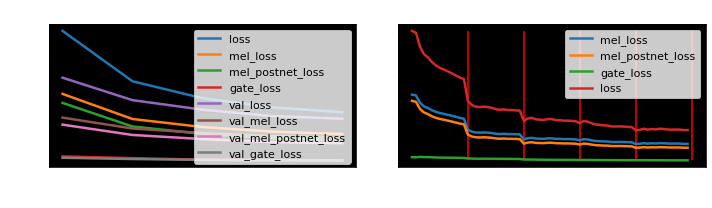

In [7]:
model.plot_history()

Just to show the power of the `History` configuration tracking :D

In [13]:
print("Training informations :")
print(pd.DataFrame(model.history.trainings_infos))
print("Training configurations :")
pd.DataFrame(model.history.trainings_config)

Training informations :
                       start                        end        time  \
0 2021-04-15 13:51:43.455931 2021-04-15 14:04:05.653112  742.197181   

   interrupted  start_epoch  final_epoch  
0        False           -1            4  
Training configurations :


,augment_prct,max_input_length,max_output_length,max_train_frames,pad_to_multiple,trim_audio,reduce_noise,trim_threshold,max_silence,trim_method,...,epochs,batch_size,valid_batch_size,test_batch_size,verbose,train_size,valid_size,test_size,pred_step,shuffle_size
0,0.25,75,512,-1,False,False,False,0.075,0.25,window,...,5,32,64,1,1,640,640,4,-1,1024


## Dataset analysis

With aa training step of 9sec, it can be interesting to see if the dataset is not the bottleneck of the training. However we can see a performance of 20 batch / sec so it is not the case, it is well the `weights update procedure` that takes so much time (but still reasonable compared to the 15-20s I had before optimization !)

In [6]:
config = model.get_dataset_config(batch_size = 32, is_validation = False, shuffle_size = 0)
ds = prepare_dataset(dataset, ** config, debug = True)

test_dataset_time(ds)

0it [00:00, ?it/s]

Original dataset : <TensorSliceDataset shapes: {text: (), filename: (), time: (), mels_22050_chann-80_filt-1024_hop-256_win-1024_norm-None: (), wavs_22050: (), wavs_44100: (), id: ()}, types: {text: tf.string, filename: tf.string, time: tf.float32, mels_22050_chann-80_filt-1024_hop-256_win-1024_norm-None: tf.string, wavs_22050: tf.string, wavs_44100: tf.string, id: tf.string}>
- Dataset after encoding : <ParallelMapDataset shapes: ((None,), (), (None, 80), (), (None, 80), (None,)), types: (tf.int32, tf.int32, tf.float32, tf.int32, tf.float32, tf.float32)>
- Dataset after filtering : <FilterDataset shapes: ((None,), (), (None, 80), (), (None, 80), (None,)), types: (tf.int32, tf.int32, tf.float32, tf.int32, tf.float32, tf.float32)>
- Dataset after augmentation : <ParallelMapDataset shapes: ((None,), (), (None, 80), (), (None, 80), (None,)), types: (tf.int32, tf.int32, tf.float32, tf.int32, tf.float32, tf.float32)>
- Dataset after batch : <PaddedBatchDataset shapes: ((None, None), (None,)

99it [00:04, 20.52it/s]


100 batchs in 4.827 sec sec (20.717 batch / sec)
Batch infos : 
Element 0 : 
 Element 0 : shape : (32, 82) - type : <dtype: 'int32'> - min : 0.000 - max : 69.000
 Element 1 : shape : (32,) - type : <dtype: 'int32'> - min : 26.000 - max : 82.000
 Element 2 : shape : (32, 441, 80) - type : <dtype: 'float32'> - min : -14.961 - max : 4.048
 Element 3 : shape : (32,) - type : <dtype: 'int32'> - min : 154.000 - max : 442.000
Element 1 : 
 Element 0 : shape : (32, 441, 80) - type : <dtype: 'float32'> - min : -11.513 - max : 1.925
 Element 1 : shape : (32, 441) - type : <dtype: 'float32'> - min : 0.000 - max : 1.000


4.827058553695679

## Waveglow inference

You should restart your kernel, execute 1st cell (imports) and then execute cells below. It allows you to test your model on complete inference pipeline with the `WaveGlow` vocoder !

In [9]:
waveglow = PtWaveGlow()
model    = Tacotron2(nom = model_name)

dataset  = get_dataset('siwis')

Loading dataset siwis...


### Inference based on dataset

In [ ]:
for idx, row in dataset.sample(2).iterrows():
    text     = row['text']
    filename = row['filename']
    
    encoded  = model.encode_text(text)
    
    # text analysis
    print("Text :\n  Original text : {}\n  Encoded text : {}\n  Decoded text : {}".format(
        text, encoded, model.decode_text(encoded)
    ))
    
    # mel analysis
    original_mel     = load_mel(filename, model.mel_fn)
    processed_mel, _ = model.get_mel_input(filename)
    
    plot_spectrogram(original = original_mel, processed = processed_mel, ncols = 1)
    
    # audio analysis
    original_audio  = load_audio(filename, rate = rate)
    inverted_audio  = waveglow.infer(original_mel)
    
    print("Original audio :")
    display_audio(original_audio, rate = rate)
    print("Waveglow inversion based on the original mel-spectrogram")
    display_audio(inverted_audio, rate = rate)
    
    # Uncomment these lines to perform Tacotron-2 inference
    #_, predicted_mel, _, _ = model.infer(tf.expand_dims(encoded, 0), [len(encoded)])
    #predicted_audio = _waveglow_infer(waveglow, predicted_mel)
    #display_audio(predicted_audio, rate = rate)



### Inference based on custom text

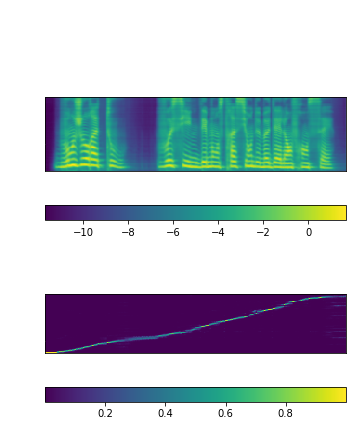

In [11]:
text = "Bonjour à tous ! Voici une démonstration du modèle en français."
# Encode text
encoded = model.encode_text(text)
# Generate mel and attention results
# The 1st output is the mel, 2nd is mel_postnet (final postnet after final processing)
# the 3rd are 'gates' (deciding when to stop generation) and 4th are attention weights
_, mel, _, attn = model.infer(tf.expand_dims(encoded, axis = 0), [len(encoded)])
# Make inference mel --> audio
audio = waveglow.infer(mel[0])
# Plot spectrogram + attention
plot_spectrogram(spectrogram = mel, attention_weights = attn)
# Display audio
_ = display_audio(audio, rate = rate)